/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow Version: 2.12.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

  TIRE QUALITY CLASSIFIER TRAINING
  MobileNetV2 Transfer Learning

PREPARING DATA

Dataset Statistics:
  Defective tires: 1028
  Good tires: 828
  Total: 1856
  Class balance: 0.81:1 (good:defective)
Found 1486 images belonging to 2 classes.
Found 370 images belonging to 2 classes.

Data Generators Created:
  Training samples: 1486
  Validation samples: 370
  Class indices: {'defective': 0, 'good': 1}

BUILDING MODEL
9406464/9406464 [==============================] - 0s 0us/step

Model Architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                  

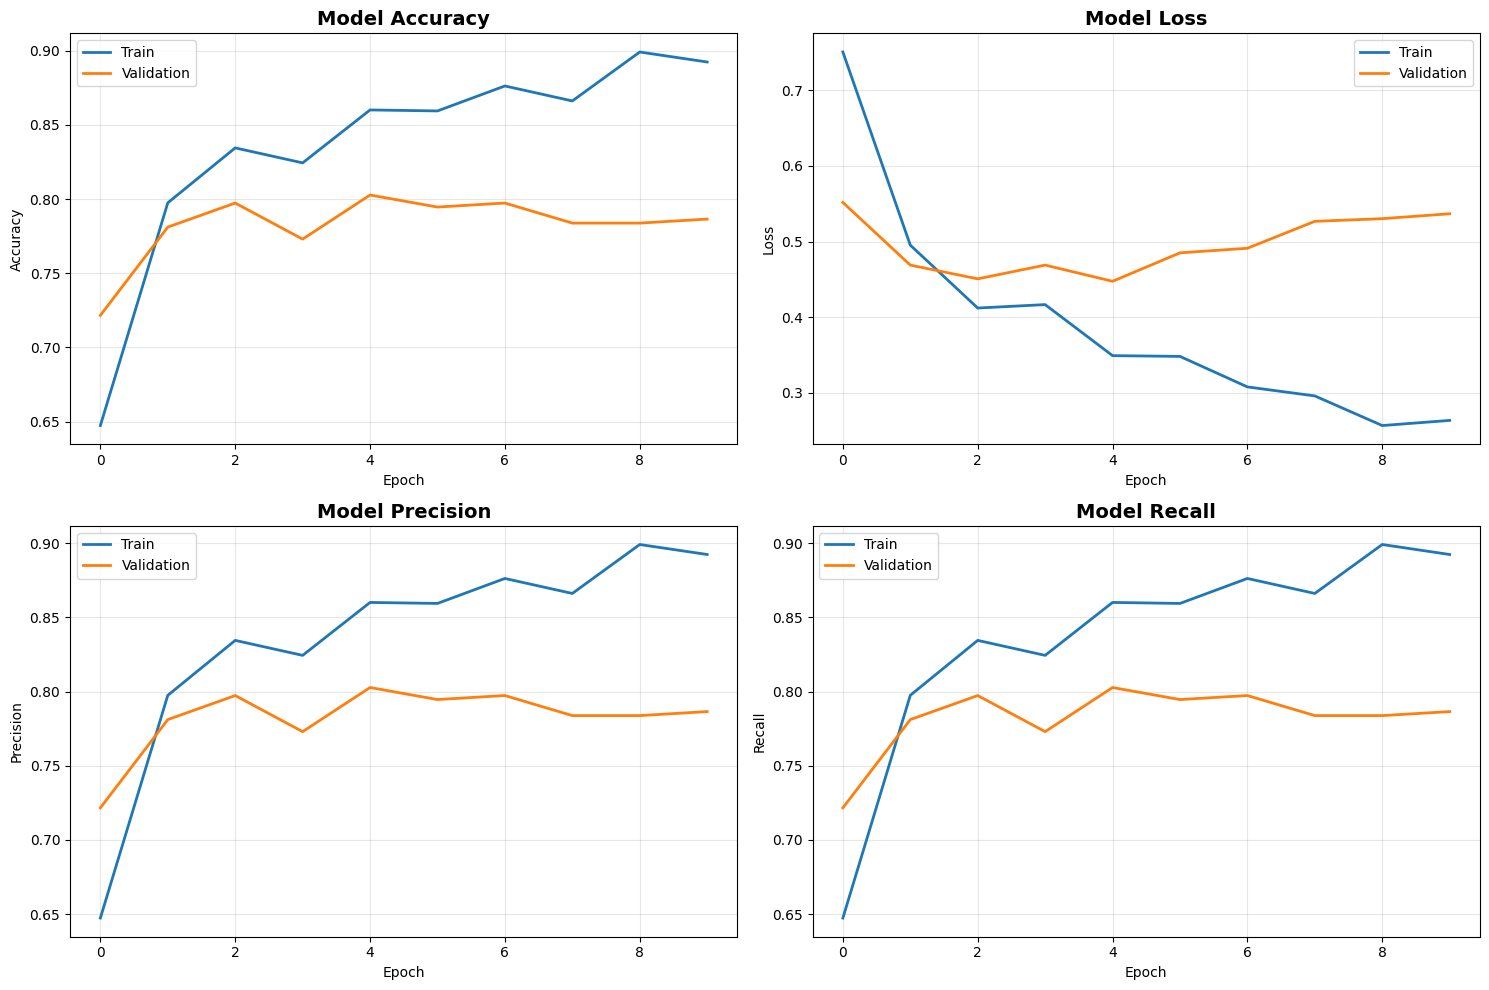


EVALUATING MODEL
12/12 [==============================] - 11s 913ms/step

Classification Report:
              precision    recall  f1-score   support

   defective     0.8929    0.7317    0.8043       205
        good     0.7277    0.8909    0.8011       165

    accuracy                         0.8027       370
   macro avg     0.8103    0.8113    0.8027       370
weighted avg     0.8192    0.8027    0.8029       370



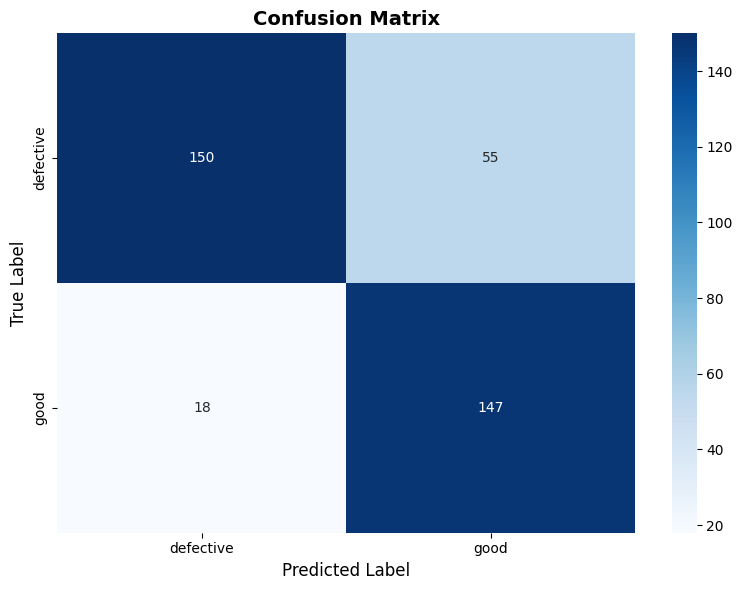


DEFECTIVE class accuracy: 73.17%

GOOD class accuracy: 89.09%

✓ Model saved: tire_classifier_mobilenetv2.h5
✓ Model size: 10.86 MB

TRAINING SUMMARY
  Final Validation Accuracy: 80.27%
  Model: tire_classifier_mobilenetv2.h5
  Total Epochs: 10
  Best Val Loss: 0.4475
  Best Val Accuracy: 80.27%


In [1]:
"""
TIRE QUALITY CLASSIFIER - KAGGLE TRAINING
MobileNetV2 Transfer Learning for Fast, Accurate Classification

Dataset Structure:
/kaggle/input/tyre-quality-classification/Digital images of defective and good condition tyres/defective
/kaggle/input/tyre-quality-classification/Digital images of defective and good condition tyres/good
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


# ==================== CONFIGURATION ====================
class Config:
    # Paths
    BASE_PATH = '/kaggle/input/tyre-quality-classification/Digital images of defective and good condition tyres'
    DEFECTIVE_PATH = os.path.join(BASE_PATH, 'defective')
    GOOD_PATH = os.path.join(BASE_PATH, 'good')
    
    # Model parameters
    IMG_SIZE = 224  # MobileNetV2 native size
    BATCH_SIZE = 32  # Increase to 64 if you have more RAM
    EPOCHS = 25
    LEARNING_RATE = 0.0001
    
    # Data split
    VALIDATION_SPLIT = 0.2
    
    # Output
    MODEL_NAME = 'tire_classifier_mobilenetv2.h5'
    
    # Classes
    CLASS_NAMES = ['defective', 'good']


# ==================== DATA PREPARATION ====================
def prepare_data():
    """
    Prepare data generators with augmentation
    """
    print("\n" + "="*70)
    print("PREPARING DATA")
    print("="*70)
    
    # Count images
    defective_count = len([f for f in os.listdir(Config.DEFECTIVE_PATH) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    good_count = len([f for f in os.listdir(Config.GOOD_PATH) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    
    print(f"\nDataset Statistics:")
    print(f"  Defective tires: {defective_count}")
    print(f"  Good tires: {good_count}")
    print(f"  Total: {defective_count + good_count}")
    print(f"  Class balance: {good_count/defective_count:.2f}:1 (good:defective)")
    
    # Data augmentation for training (helps with small datasets)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        zoom_range=0.2,
        shear_range=0.15,
        fill_mode='nearest',
        validation_split=Config.VALIDATION_SPLIT
    )
    
    # No augmentation for validation (only rescaling)
    val_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=Config.VALIDATION_SPLIT
    )
    
    # Training generator
    train_generator = train_datagen.flow_from_directory(
        Config.BASE_PATH,
        target_size=(Config.IMG_SIZE, Config.IMG_SIZE),
        batch_size=Config.BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=42
    )
    
    # Validation generator
    val_generator = val_datagen.flow_from_directory(
        Config.BASE_PATH,
        target_size=(Config.IMG_SIZE, Config.IMG_SIZE),
        batch_size=Config.BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False,
        seed=42
    )
    
    print(f"\nData Generators Created:")
    print(f"  Training samples: {train_generator.samples}")
    print(f"  Validation samples: {val_generator.samples}")
    print(f"  Class indices: {train_generator.class_indices}")
    
    return train_generator, val_generator


# ==================== MODEL CREATION ====================
def create_model():
    """
    Create MobileNetV2 transfer learning model
    """
    print("\n" + "="*70)
    print("BUILDING MODEL")
    print("="*70)
    
    # Load pre-trained MobileNetV2 (without top classification layer)
    base_model = MobileNetV2(
        input_shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model initially
    base_model.trainable = False
    
    # Build classification head
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(2, activation='softmax')  # Binary: good/defective
    ])
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=Config.LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )
    
    print("\nModel Architecture:")
    model.summary()
    
    print(f"\nTotal parameters: {model.count_params():,}")
    print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
    
    return model


# ==================== TRAINING ====================
def train_model(model, train_gen, val_gen):
    """
    Train the model with callbacks
    """
    print("\n" + "="*70)
    print("TRAINING MODEL")
    print("="*70)
    
    # Callbacks
    callbacks = [
        # Early stopping
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Reduce learning rate on plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        
        # Save best model
        ModelCheckpoint(
            Config.MODEL_NAME,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    
    # Train
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=Config.EPOCHS,
        callbacks=callbacks,
        verbose=1
    )
    
    print("\n✓ Training completed!")
    
    return history


# ==================== EVALUATION ====================
def evaluate_model(model, val_gen):
    """
    Evaluate model performance
    """
    print("\n" + "="*70)
    print("EVALUATING MODEL")
    print("="*70)
    
    # Get predictions
    val_gen.reset()
    predictions = model.predict(val_gen, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_gen.classes
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, 
                                target_names=Config.CLASS_NAMES,
                                digits=4))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=Config.CLASS_NAMES,
                yticklabels=Config.CLASS_NAMES)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=150)
    plt.show()
    
    # Calculate metrics
    accuracy = np.sum(y_pred == y_true) / len(y_true)
    
    # Per-class metrics
    for i, class_name in enumerate(Config.CLASS_NAMES):
        class_mask = (y_true == i)
        class_accuracy = np.sum((y_pred == y_true) & class_mask) / np.sum(class_mask)
        print(f"\n{class_name.upper()} class accuracy: {class_accuracy*100:.2f}%")
    
    return accuracy


# ==================== VISUALIZATION ====================
def plot_training_history(history):
    """
    Plot training curves
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train', linewidth=2)
    axes[1, 0].plot(history.history['val_precision'], label='Validation', linewidth=2)
    axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train', linewidth=2)
    axes[1, 1].plot(history.history['val_recall'], label='Validation', linewidth=2)
    axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=150)
    plt.show()


# ==================== MAIN PIPELINE ====================
def main():
    """
    Complete training pipeline
    """
    print("\n" + "="*70)
    print("  TIRE QUALITY CLASSIFIER TRAINING")
    print("  MobileNetV2 Transfer Learning")
    print("="*70)
    
    # Step 1: Prepare data
    train_gen, val_gen = prepare_data()
    
    # Step 2: Create model
    model = create_model()
    
    # Step 3: Train model
    history = train_model(model, train_gen, val_gen)
    
    # Step 4: Plot training history
    plot_training_history(history)
    
    # Step 5: Evaluate model
    accuracy = evaluate_model(model, val_gen)
    
    # Step 6: Save final model
    model.save(Config.MODEL_NAME)
    print(f"\n✓ Model saved: {Config.MODEL_NAME}")
    print(f"✓ Model size: {os.path.getsize(Config.MODEL_NAME) / (1024*1024):.2f} MB")
    
    # Final summary
    print("\n" + "="*70)
    print("TRAINING SUMMARY")
    print("="*70)
    print(f"  Final Validation Accuracy: {accuracy*100:.2f}%")
    print(f"  Model: {Config.MODEL_NAME}")
    print(f"  Total Epochs: {len(history.history['loss'])}")
    print(f"  Best Val Loss: {min(history.history['val_loss']):.4f}")
    print(f"  Best Val Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
    print("="*70)
    
    return model, history


# ==================== RUN ====================
if __name__ == "__main__":
    model, history = main()